In [ ]:
!pip install gradio

In [1]:
import os
import cv2
import numpy as np
from google.colab import files
import shutil
import glob

# Clone Real-ESRGAN and enter the Real-ESRGAN directory
!git clone https://github.com/xinntao/Real-ESRGAN.git
%cd Real-ESRGAN

# Set up the environment
!pip install basicsr
!pip install facexlib
!pip install gfpgan
!pip install -r requirements.txt
!python setup.py develop

Cloning into 'Real-ESRGAN'...
remote: Enumerating objects: 755, done.
remote: Total 755 (delta 0), reused 0 (delta 0), pack-reused 755
Receiving objects: 100% (755/755), 5.37 MiB | 29.39 MiB/s, done.
Resolving deltas: 100% (410/410), done.
/content/Real-ESRGAN
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 99.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 kB 26.4 MB/s eta 0:00:00
  Created wheel for basicsr: filename=basicsr-1.4.2-py3-none-any.whl size=214822 sha256=23b62f92717f9c3ea02182e65cb05d176c4a4caa884c088d3fc353f586c5057d
  Stored in directory: /root/.cache/pip/wheels/38/83/99/2d8437cc652a01af27df5ff037a4075e95b52d67705c5f30ca
Successfully buil

In [2]:
# Create a folder to store the splits
upload_folder = 'upload'
splits_folder = 'splits'
result_folder = 'results'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
if os.path.isdir(splits_folder):
        shutil.rmtree(splits_folder)
if os.path.isdir(result_folder):
    shutil.rmtree(result_folder)
os.mkdir(upload_folder)
os.mkdir(splits_folder)
os.mkdir(result_folder)    

In [3]:
def split_image(image_path, n):
    img = cv2.imread(image_path)
    height, width, _ = img.shape
    split_height = height // int(n ** 0.5)
    split_width = width // int(n ** 0.5)

    # Split the image into n**0.5 rows and n**0.5 columns
    splits = []
    for i in range(int(n ** 0.5)):
        for j in range(int(n ** 0.5)):
            split = img[i * split_height : (i + 1) * split_height, j * split_width : (j + 1) * split_width, :]
            splits.append(split)
            # Save the splits in the splits folder
            cv2.imwrite(os.path.join(splits_folder, f'split_{i}_{j}.png'), split)

    return splits_folder

In [4]:
def process_image(input_folder, output_folder):
    input_list = sorted(glob.glob(os.path.join(input_folder, '*')))
    #os.makedirs(output_folder, exist_ok=True)
    
    for idx, input_path in enumerate(input_list):
        # Apply ESRGAN to each split
        output_path = os.path.join(output_folder)
        !python inference_realesrgan.py -n RealESRGAN_x4plus -i $input_path -o $output_path --outscale 3.5 --face_enhance

        # Move the processed image to the 'results' folder
        shutil.move(output_path, os.path.join(output_folder))

    return output_folder


In [5]:
def merge_images(splits_folder, output_folder, n):
    # Load the processed split images
    splits_list = sorted(glob.glob(os.path.join(splits_folder, '*')))
    merged_rows = []
    for i in range(int(n ** 0.5)):
        row_splits = [cv2.imread(split) for split in splits_list[i * int(n ** 0.5) : (i + 1) * int(n ** 0.5)]]
        merged_row = np.hstack(row_splits)
        merged_rows.append(merged_row)
    merged = np.vstack(merged_rows)

    # Save the final output image
    cv2.imwrite(os.path.join(result_folder, 'final_output.png'), merged)

    return merged

def apply_filter(image):
    # Code for applying the filter
    kernel_size = 5
    filtered_img = cv2.medianBlur(image, kernel_size)
    return filtered_img

In [6]:
# Upload the image
uploaded = files.upload()
input_image_path = list(uploaded.keys())[0]

# Take user input for n
n = int(input("Enter the number of splits (n): "))

# Split the input image
splits_folder = split_image(input_image_path, n)

Saving capybara.jpg to capybara.jpg
Enter the number of splits (n): 9


In [7]:
# Apply ESRGAN to the split images
output_folder = process_image(splits_folder, 'results')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
Downloading: "https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth" to /content/Real-ESRGAN/weights/RealESRGAN_x4plus.pth

100% 63.9M/63.9M [00:01<00:00, 66.0MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current 

In [8]:
# Merge the processed images to produce the final output
final_output = merge_images(result_folder, output_folder, n)

Do you want to apply a low pass filter to the image? (yes/no): yes


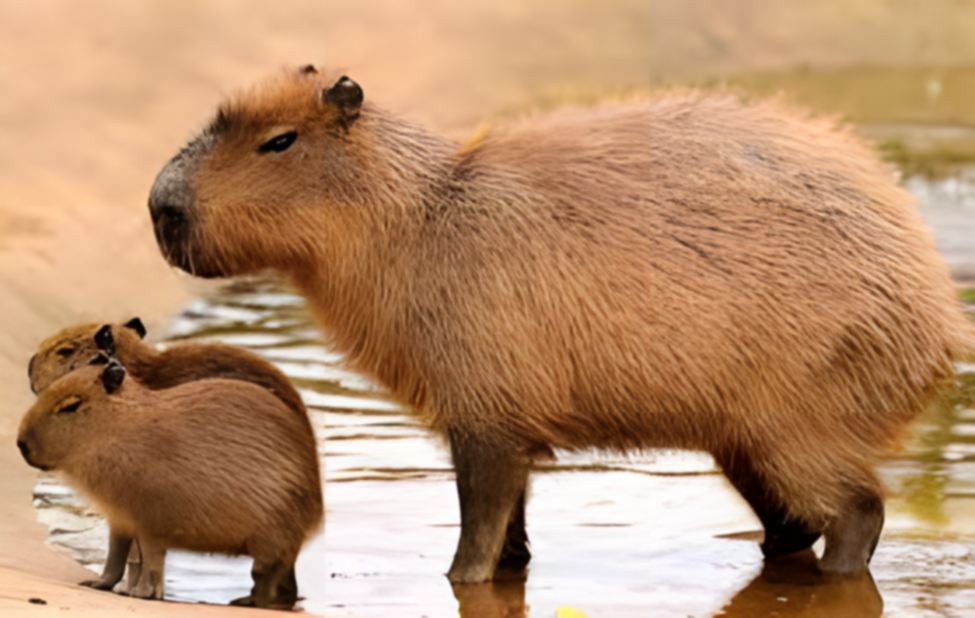

In [14]:
from google.colab.patches import cv2_imshow

# Ask the user if they want to apply a low pass filter
apply_filter = input("Do you want to apply a low pass filter to the image? (yes/no): ")

if apply_filter.lower() == "yes":
    # Define the low pass filter parameters (you can adjust these as needed)
    kernel_size = (5, 5)
    sigma = 0

    # Apply the low pass filter to the final output
    final_output_filtered = cv2.GaussianBlur(final_output, kernel_size, sigma)

    # Save and display the filtered output
    cv2.imwrite(os.path.join(result_folder, 'final_output_filtered.png'), final_output_filtered)
    cv2_imshow(final_output_filtered)
else:
    # Display the final output without applying the filter
    cv2_imshow(final_output)